# Importing Libraries

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import color,filters,feature,exposure
from scipy import signal as sig
from scipy import ndimage 

# Read in images

In [3]:
img_83 = plt.imread("./images/image-83.jpg")
img_83_rescaled = cv.resize(img_83,(640,480))
img_83_hog = cv.resize(img_83,(256,192))
img_83_grayscale = cv.cvtColor(img_83,cv.COLOR_RGB2GRAY)
# img_110_grayscale = cv.normalize(img_83_grayscale, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
img_83_grayscale_rescaled = cv.resize(img_83_grayscale,(640,480))
img_83_mask = cv.cvtColor(plt.imread("./images/mask-83.png"),cv.COLOR_RGB2GRAY)
img_83_mask_rescaled = cv.resize(img_83_mask,(640,480))


# 1) Canny Edge Detector

## 1.1)
Implement the Canny edge detection algorithm from scratch, your function should accept a
greyscale image and three tuneable named parameters (defaults are given below): σ, low threshold
and high threshold, similar in behaviour to that of the skimage canny edge detector.

### Step 1
Remove any unnecessary noise by applying a Gaussian filter with σ = 4 to your greyscale
image. Estimate the size of your Gaussian filter with the equation size = 2 · radius + 1,
where radius = f loor(truncate · σ + 0.5), and truncate = 4.0 is the number of standard
deviations away to truncate the filter.

In [4]:
def remove_noise(img, sigma =4.0 , truncate = 4.0,plot=False):
    radius = np.floor(truncate*sigma + 0.5)

    size = 2*radius + 1
    result = filters.gaussian(img,sigma,mode = 'nearest')
    if plot:
        print("------------------------------------ Gaussian Blur Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title(f"Gaussian blur using kernel size {size}")
        plt.show()
    return result


### Step 2
Calculate the intensity gradient of the image, comprised of orientation and magnitudes,
using vertical and horizontal Sobel filters.

In [5]:
def intensity_gradient(img,plot=False):

    sobelx = cv.Sobel(img,cv.CV_64F,1,0,borderType = cv.BORDER_REFLECT)
    sobely = cv.Sobel(img,cv.CV_64F,0,1, borderType = cv.BORDER_REFLECT)
    magnitude = np.hypot(sobelx,sobely)
    magnitude = magnitude/magnitude.max() * 255
    orientation = np.arctan2(sobely, sobelx)
    if plot:
        print("------------------------------------ Intensity Gradients Result ------------------------------------")
        fig,ax = plt.subplots(nrows = 1, ncols = 4,figsize = (10,10),sharex=True,sharey=True)
        plt.subplot(1,4,1),plt.imshow(sobelx,cmap="gray"),plt.title("Sobel Horizontal")
        plt.subplot(1,4,2),plt.imshow(sobely,cmap="gray"),plt.title("Sobel Vertical")
        plt.subplot(1,4,3),plt.imshow(magnitude,cmap="gray"),plt.title("Sobel Magnitude")
        plt.subplot(1,4,4),plt.imshow(orientation,cmap="gray"),plt.title("Sobel Orientation")
        plt.show()
    return sobelx,sobely,magnitude,orientation

### Step 3
Apply non-maximum suppression to get rid of any unwanted pixels which may not form
part of an edge, leaving you with the “thin edges”.

In [6]:
def non_max_suppression(img, orientation,plot=False):
    M, N = img.shape
    result = np.zeros((M,N), dtype=np.float32)
    angle = orientation * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    result[i,j] = img[i,j]
                
                # if not ((img[i][j] >= q) and (img[i][j] >= r)):
                #         result[i][j] = 0
                else:
                    result[i,j] = 0
    if plot:
        print("------------------------------------ Non-maximum Suppression Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title("Non-maximum suppression")
        plt.show()
    
    return result

### Step 4
Apply double thresholding to determine potential edges. Use the weak/low threshold value
of 0.1 and strong/high threshold value of 0.2.

In [7]:
def threshold(img,high,low,plot=False):
    high = img.max() * high;
    low = high * low;
    result = np.zeros(np.shape(img))
    ## Weak pixels are between the high and low thresholds
    weak = np.where((img<high) & (img>=low))
    ## strrong pixels are higher than high
    strong = np.where(img >= high)

    result[strong] = 1
    result[weak] = 0.1
    if plot:
        print("------------------------------------ Double Thresholding Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title("Double thresholding")
        plt.show()
    return result,0.1,1

### Step 5
Track edges by Hysteresis, where weak edges are suppressed if not connected to strong
edges.

In [8]:
def hysteresis(img, weak = 0.1, strong=1,plot=False):
    M, N = np.shape(img)  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                    tmp = np.array(img[i-1:i+2,j-1:j+2])
                    if(np.any(tmp== 1)):
                        img[i,j] = strong
                    else:
                        img[i, j] = 0
    if plot:

        print("------------------------------------ Hysteresis Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(img,cmap="gray")
        plt.title("Hysteresis")
        plt.show()
    return img

### Putting all the steps together

In [9]:
def Canny_Edge_Detector(img,sigma = 4,low_threshold = 0.1,high_threshold = 0.2,plot=False):
    ## Blur image
    img = np.copy(img)
    blurred = remove_noise(img,plot=plot)
    ## Get intensity gradients
    ig = intensity_gradient(blurred,plot=plot)
    ## Non-maximum suppression
    suppressed = non_max_suppression(ig[2],ig[3],plot=plot)
    double_thresholding = threshold(suppressed,high_threshold,low_threshold,plot=plot)
    final = hysteresis(double_thresholding[0],plot=plot)
    return final

## 1.2) 
Plot and label the results after each step in the Canny algorithm, include the blurred greyscale
image (labelled with the estimated size of your Gaussian filter), horizontal and vertical Sobel
filtered images, orientation and magnitude images, non-maximum suppressed image, double
thresholded images, and the final result after Hysteresis. Make sure to label each image.

------------------------------------ Gaussian Blur Result ------------------------------------


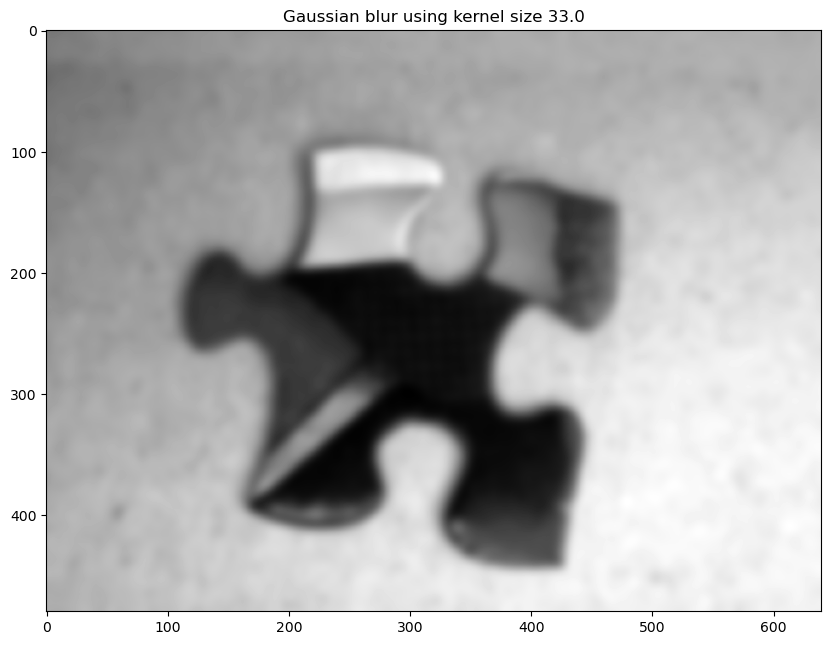

------------------------------------ Intensity Gradients Result ------------------------------------


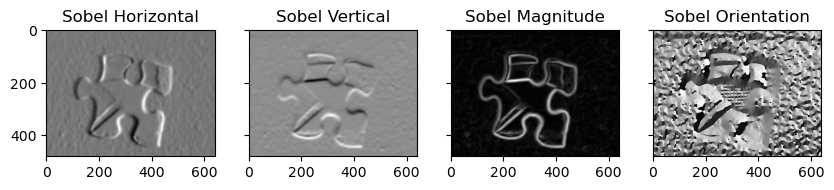

------------------------------------ Non-maximum Suppression Result ------------------------------------


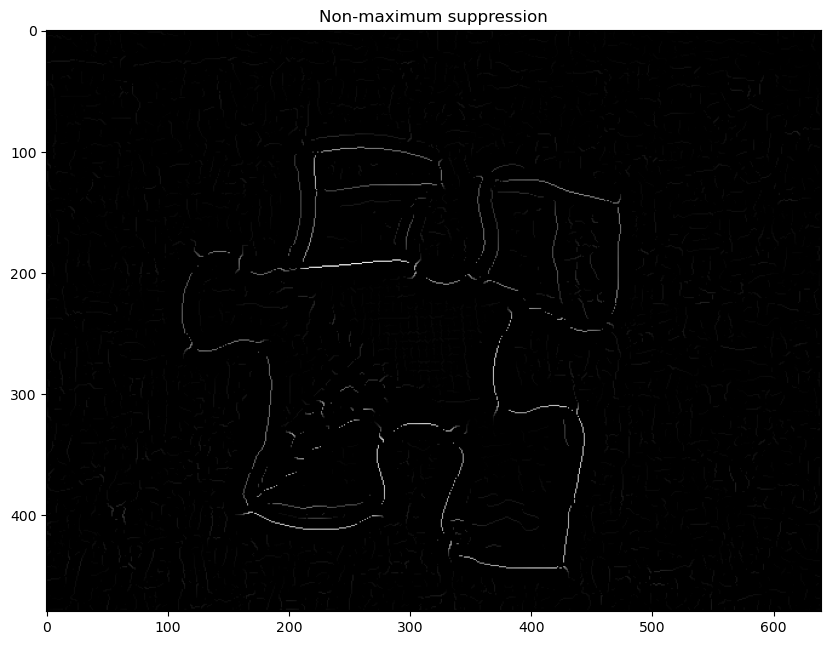

------------------------------------ Double Thresholding Result ------------------------------------


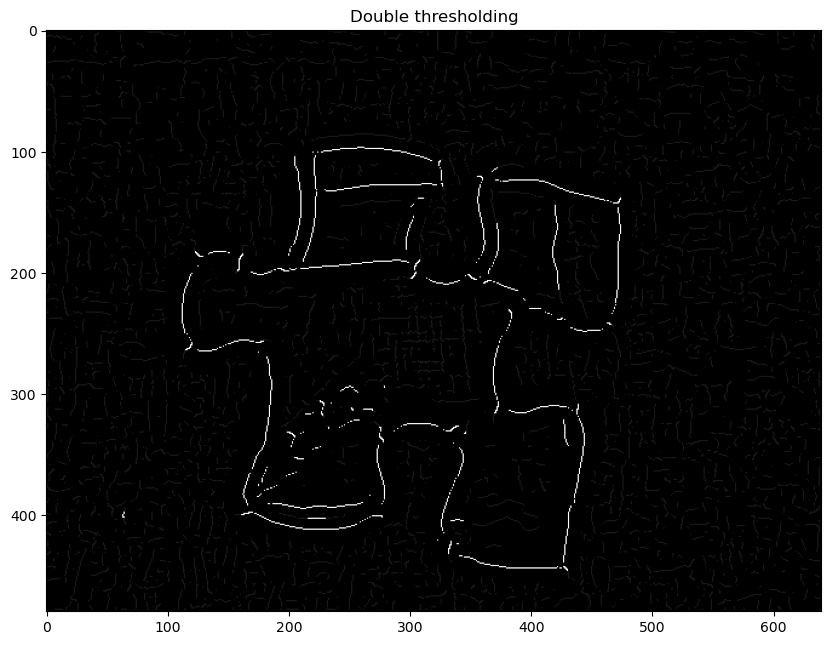

------------------------------------ Hysteresis Result ------------------------------------


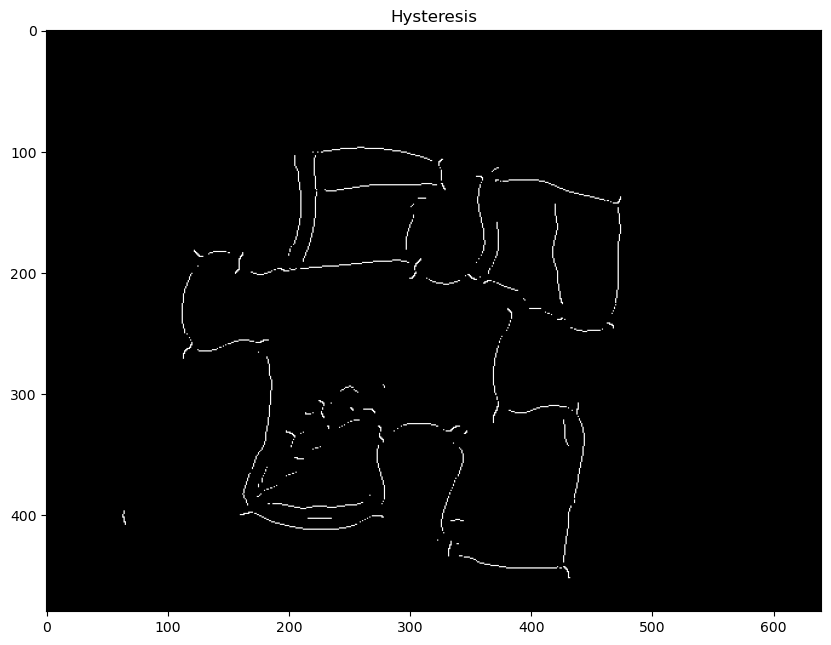

In [10]:
res = Canny_Edge_Detector(img_83_grayscale_rescaled,plot=True)

## 1.3) 
Compare your final result to the skimage canny function (skimage.feature.canny) run with
default arguments.

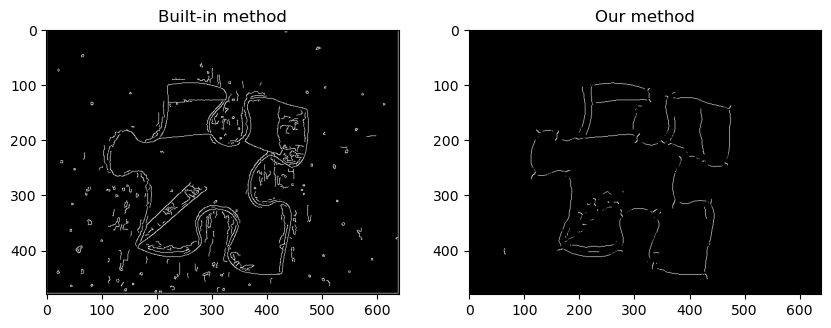

In [11]:
plt.figure(figsize=(10,10))
built_in = feature.canny(img_83_grayscale_rescaled)
plt.subplot(1,2,1),plt.imshow(built_in,cmap="gray"),plt.title("Built-in method")
plt.subplot(1,2,2),plt.imshow(res,cmap="gray"),plt.title("Our method")
plt.show()

## 1.4)
Give reasons for the effect on the output after increasing or decreasing each parameter, including
low threshold, high threshold and σ. Plot your different parameter traversals used to come to
your conclusions. You may use the skimage.feature.canny function for this question.

### Investigating the effect of $\sigma$

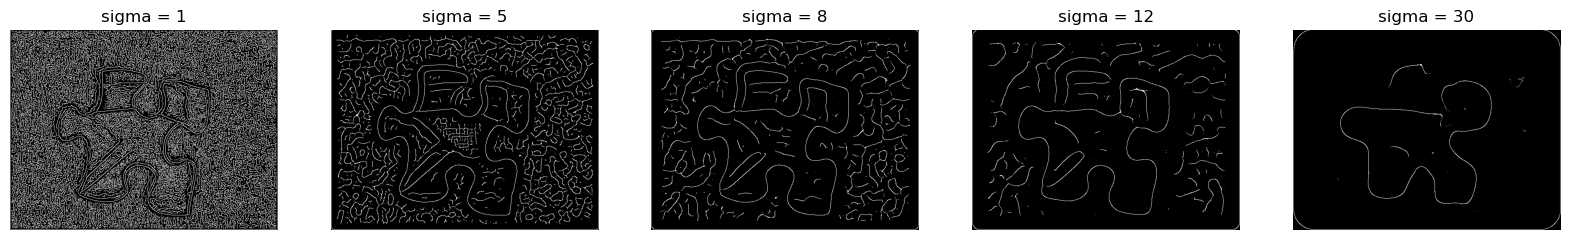

In [12]:
sigma_vals = [1, 5, 8, 12,30]
plt.figure(figsize=(20,20))
index = 1
for sigma in sigma_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, sigma, 0.1, 0.2), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title("sigma = %d" % sigma)


- Lower values of $\sigma$ give us noiser images. The additional noise is then captured as an edge by the algorithm.
- Higher $\sigma$ values reduce the noise, and thus enable the algorithm to capture the correct edges in the image.
- However, as we increaser sigma, fewer and fewer edges are captured since they become blurred by the gaussian kernel.

### Investigating the effect of the high threshold

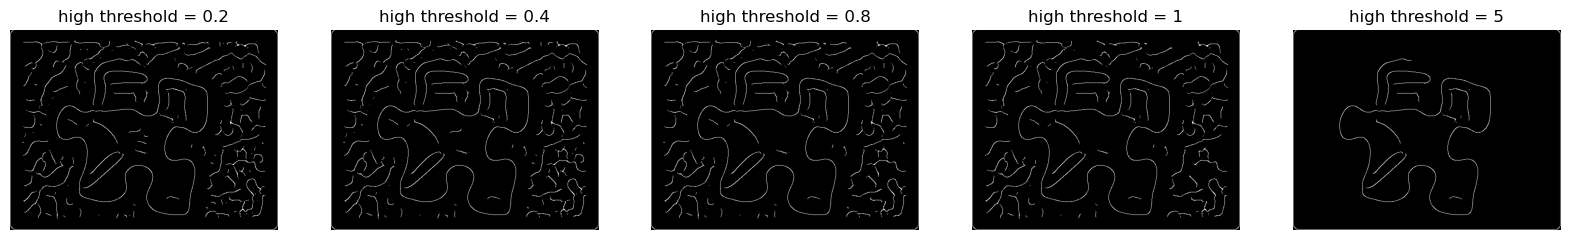

In [13]:
high_threshold_vals = [0.2,0.4,0.8,1,5]
plt.figure(figsize=(20,20))
index = 1
for t in high_threshold_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, 10, 0.1,t), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title(f"high threshold = {t}")


- Higher values for the high threshold enables us to preserve fewer edges since the threshold means we need to be more sure of an edge.
- However, there exists a cutoff point where beyond this point, the algorithm may actually remove legitimate edges because the threshold is too high.

### Investigating the effects of the low threshold

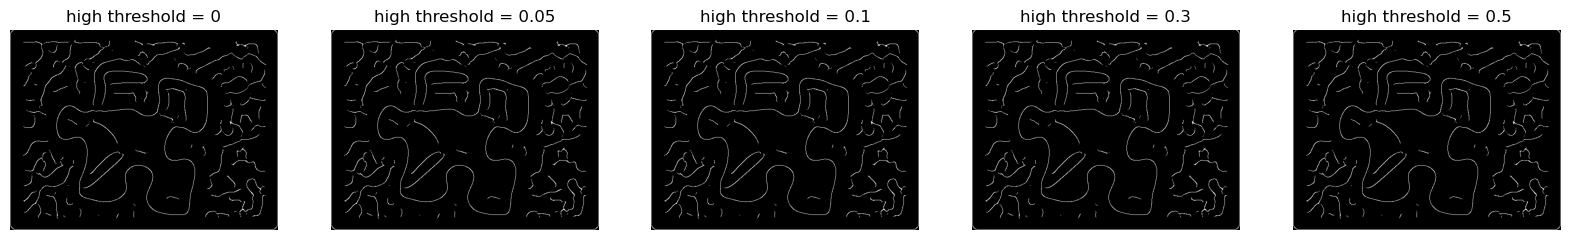

In [14]:
low_threshold_vals = [0, 0.05, 0.1, 0.3, 0.5]
# low_threshold_vals = [3,2,1,0.5,0]
plt.figure(figsize=(20,20))
index = 1
for t in low_threshold_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, 10, t,1), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title(f"high threshold = {t}")

## 1.5)
Adjust the parameters of your implementation to try and obtain the best or cleanest result. Plot
this result with your chosen parameters. Again you may use the skimage.feature.canny
function.

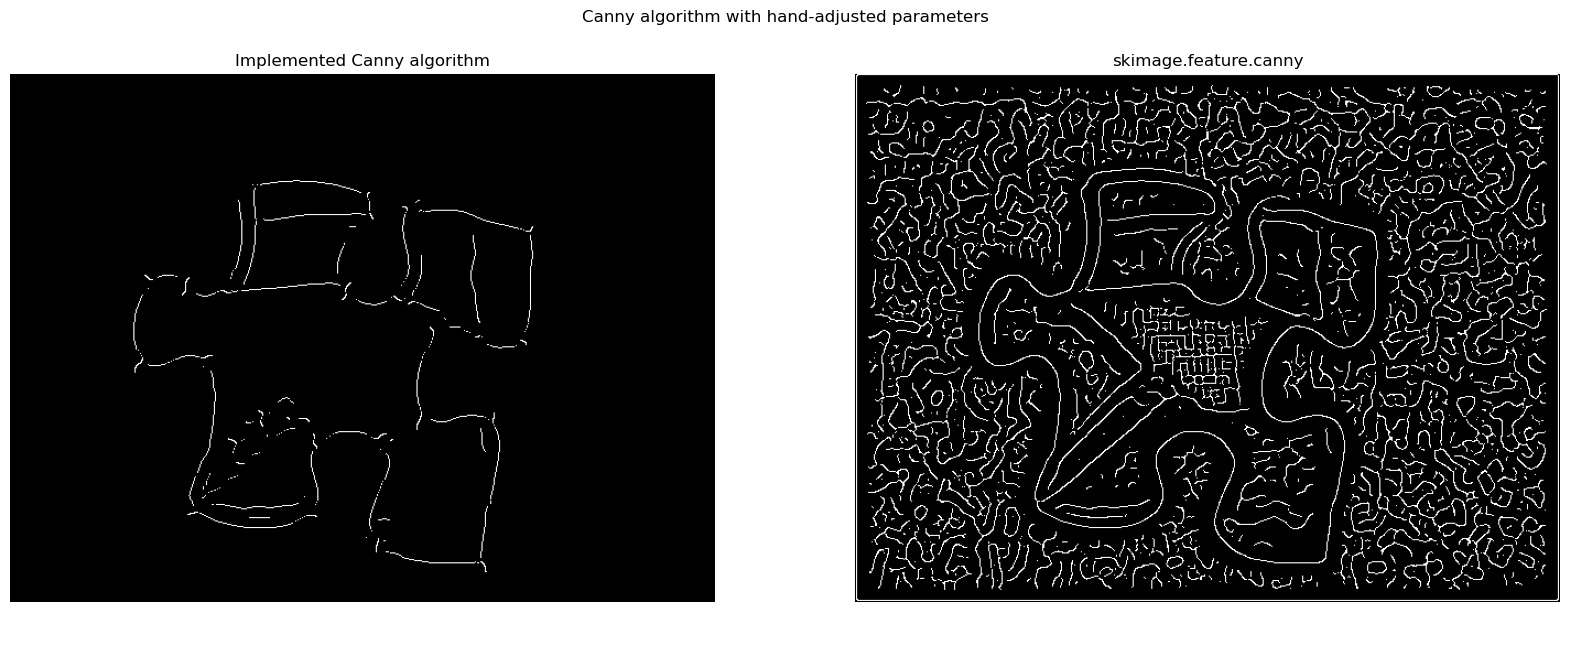

In [15]:
sigma = 4
low_threshold = 0.1
high_threshold = 0.23

canny_best= Canny_Edge_Detector(img_83_grayscale_rescaled, sigma, low_threshold=low_threshold, high_threshold=high_threshold)

fig6 = plt.figure(figsize=(20,8))
plt.axis("Off")
plt.title("Canny algorithm with hand-adjusted parameters")
fig6.add_subplot(1, 2, 1)
plt.axis("Off")
plt.title("Implemented Canny algorithm")
plt.imshow(canny_best, cmap="gray")
fig6.add_subplot(1, 2, 2)
plt.axis("Off")
plt.title("skimage.feature.canny")
plt.imshow(feature.canny(img_83_grayscale_rescaled, sigma, low_threshold, high_threshold), cmap="gray")
plt.show()

# 2) Harris Corner Detector

## 2.1) 
Your task is to implement the Harris Corner Detector, your function signature should accept a
greyscale image with three additional tuneable named parameters (defaults are given below): $\sigma, \kappa, \tau$, where $\sigma$ is the standard deviation of the Gaussian filter representing the weight matrix,
$\kappa$  is the sensitivity factor that separates corners from edges and $\tau$  is the normalised response
threshold.

### Step 1
Compute your vertical and horizontal image derivatives from your greyscale image using
the appropriately oriented Sobel filters and zero padding.

In [16]:
def img_derivatives(img):
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    sobelx = sig.convolve2d(img, kernel_x, mode='same')
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    sobely= sig.convolve2d(img, kernel_y, mode='same')
    return sobelx,sobely

### Step 2
Use these derivatives to compute your image structure tensors ($S_{ij}$ in your textbook),
weighted according to the Gaussian with default $\sigma$ = 1. Again use zero padding.

In [17]:
def create_structure_tensors(sobelx,sobely,sigma):
    truncate= 4
    radius = np.floor((truncate*sigma)+0.5)
    size = int((2*radius) + 1)
    I_xx = cv.GaussianBlur(sobelx**2, (size,size), sigma, borderType=cv.BORDER_CONSTANT)
    I_yy = cv.GaussianBlur(sobely**2, (size, size), sigma, borderType=cv.BORDER_CONSTANT)
    I_xy = cv.GaussianBlur(sobely*sobelx, (size, size), sigma, borderType=cv.BORDER_CONSTANT)

    return I_xx,I_yy,I_xy

### Step 3
Calculate the responses (cij ) from the structure tensors, with the default value for $\kappa$ = 0.05.

In [18]:
def response_structure_tensor(I_xx,I_yy,I_xy,kappa):
    trace = I_xx + I_yy
    determinant = (I_xx * I_yy) - (I_xy**2)
    response = determinant - (kappa*(trace**2))
    return response

### Step 4
Remove spurious corners from the responses by only keeping local maxima, do this by
analysing the 8 neighbouring values of the centre value in a 3x3 sliding window and keeping the centre only if it is greater than or equal to its neighbours.

In [19]:
def remove_spurious_corners(img):
  result = img.copy()
  rows,cols = np.shape(img)

  img_padded = cv.copyMakeBorder(img, 1, 1, 1, 1, borderType=cv.BORDER_CONSTANT, value=0)
  for i in range(1, rows - 1):
    for j in range(1, cols - 1):
      neighbours = img_padded[i-1:i+2,j-1:j+2]
      maximum = np.amax(neighbours)

      if img_padded[i][j] > maximum:
        result[i][j] = img_padded[i][j]
      else:
        result[i][j] = maximum

  return result

### Step 5
Use the default threshold ratio $\tau$ = 0.05 to return the points where $\frac{responses}{max(responses)} > \tau$.

In [20]:
def getPoints(img,tau):
    # maximum = max([max(p) for p in img])
    # points = []
    # dim = np.shape(img)
    # for i in range(dim[0] - 1):
    #     for j in range(dim[1] - 1):
    #         if img[i][j]/maximum > tau:
    #             points.append([i, j])


    tmp = img.copy()
    max2 = np.amax(tmp)
    tmp = tmp/max2

    points = np.where(tmp > tau)

    return points

### Putting all the steps together

In [21]:
def Harris_Corner_Detector(img , sigma = 1, kappa = 0.05, tau = 0.05):
    sobelx,sobely = img_derivatives(img)
    Ix,Iy,Ixy = create_structure_tensors(sobelx,sobely,sigma)
    response = response_structure_tensor(Ix,Iy,Ixy,kappa)
    no_spurious_corners = remove_spurious_corners(response)
    corners = getPoints(no_spurious_corners,tau)
    return sobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners

## 2.2) 
Apply your Harris corner detector to the mask image with default arguments and plot the de-
tected corners by drawing circles around them.

In [22]:
def draw_circles(img,points):
  result = img.copy()
  n = len(points[0])
  for i in range (n):
    cv.circle(result, (points[1][i],points[0][i]), radius=12, color=(0,255,0), thickness=2)
  return result

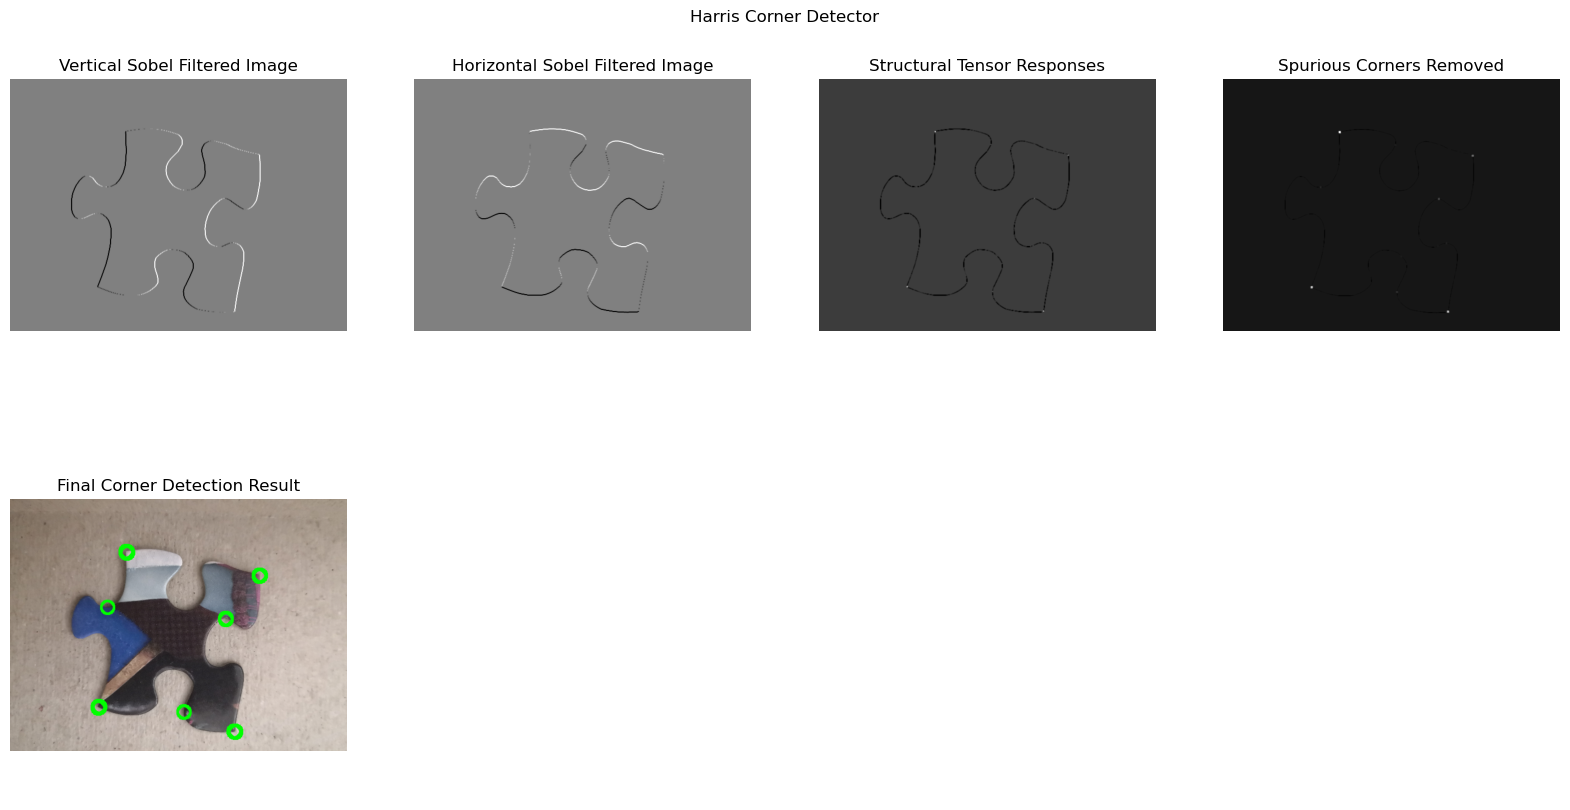

In [23]:
sobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled)

fig = plt.figure(figsize=(20, 10))
plt.axis("Off")
plt.title("Harris Corner Detector")

fig.add_subplot(2, 4, 1)
plt.axis("Off")
plt.title("Vertical Sobel Filtered Image")
plt.imshow(sobelx, cmap="gray")

fig.add_subplot(2, 4, 2)
plt.axis("Off")
plt.title("Horizontal Sobel Filtered Image")
plt.imshow(sobely, cmap="gray")

fig.add_subplot(2, 4, 3)
plt.axis("Off")
plt.title("Structural Tensor Responses")
plt.imshow(response, cmap="gray")

fig.add_subplot(2, 4, 4)
plt.axis("Off")
plt.title("Spurious Corners Removed")
plt.imshow(no_spurious_corners, cmap="gray")

fig.add_subplot(2, 4, 5)
plt.axis("Off")
plt.title("Final Corner Detection Result")
plt.imshow(draw_circles(img_83_rescaled, corners))

plt.show()

### 2.3 
Test different values of $\kappa \in {0.025, 0.05, 0.1, 0.2}$, $ \sigma \in {1, 2, 4, 8}$  and $ \tau \in {0.01, 0.05, 0.1, 0.2}$
with your implementation of the Harris corner detector. You do not need to run through all
permutations of parameters, rather plot a traversal for each parameter and keep the remainder
as the defaults (one plot for each parameter, with a labelled image corresponding to each pa-
rameter value in the set). Perform these tests on the greyscale version of the original image, not
your mask. Draw the points on your images as in the previous question.

### Investigating the effects of $\sigma$

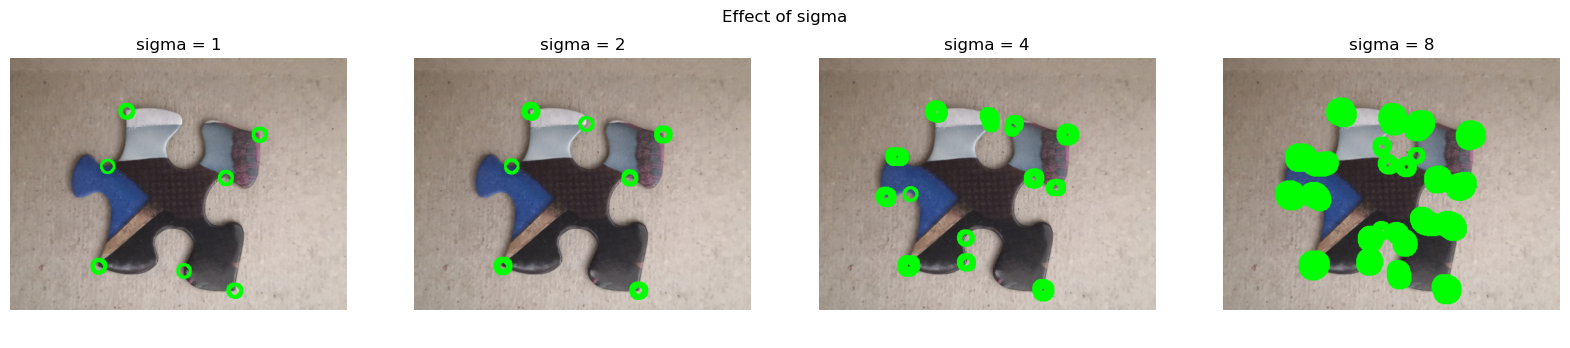

In [24]:
sigmas = [1, 2, 4, 8]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of sigma")
index = 1
for sigma in sigmas:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, sigma=sigma)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"sigma = {int(sigma)}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- Increasing $\sigma$ leads to an increase in the total number of corners identified.
- The increase in $\sigma$  also leads to the points classified as corners to be more closely clustered. Hence we have the thick circles.

### Investigating the effects of $\kappa$

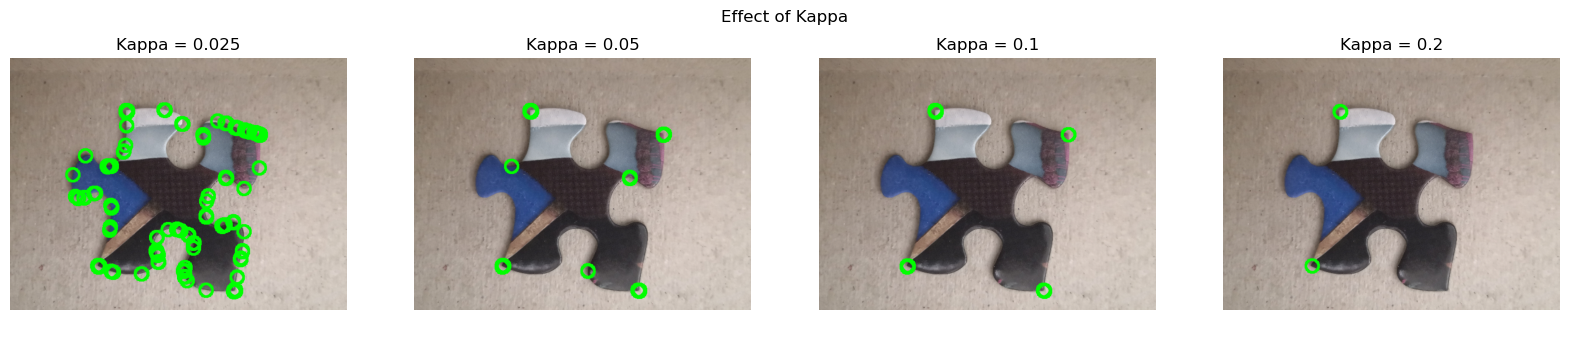

In [25]:
kappas = [0.025,0.05,0.1,0.2]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of Kappa")
index = 1
for kappa in kappas:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, kappa=kappa)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"Kappa = {kappa}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- As we increase $\kappa$, the number of corners detected decreases.
- We need to be wary of having too large a $\kappa$ value, since this will lead to the removal of corners of the image which are important features.

### Investigating the effect of $\tau$

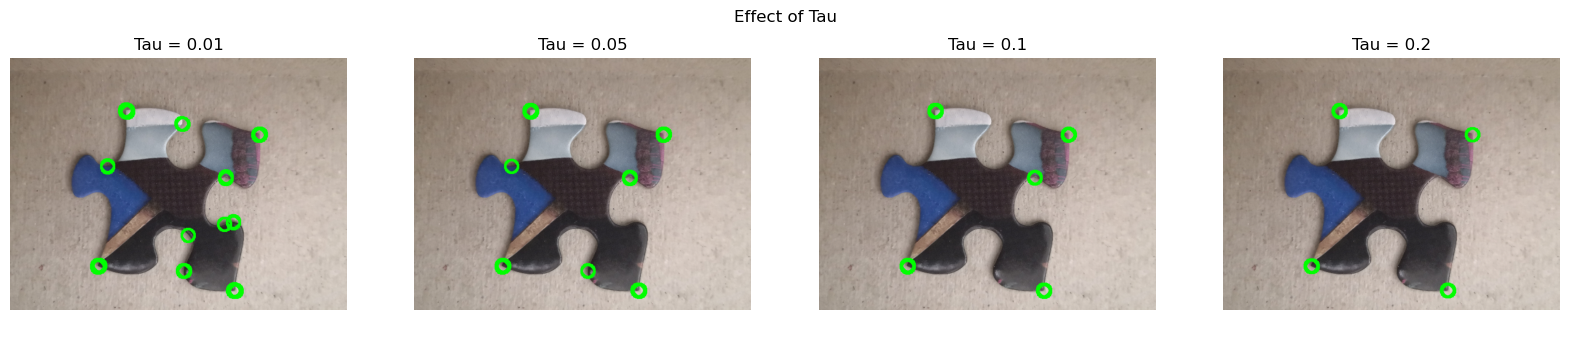

In [26]:
taus = [0.01,0.05,0.1,0.2]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of Tau")
index = 1
for tau in taus:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, tau=tau)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"Tau = {tau}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- Increasing $\tau$ leads to a decrease in the total number of corners identified.
- The increase in $\tau$  also leads to the points classified as corners to be further clustered. Hence we have fewer and more isolated circles.

## 2.4 
How could you further reduce the number of points that are closely clustered together?

# 3) Histogram of Oriented Gradients Descriptor

## 3.1 
Your final task is to implement the Histogram of Oriented Gradients Descriptor (HoG). Create a function that accepts an RGB image and three named arguments orientations = 9,
pixels per cell = 8 and cells per block = 2, the cell size is the number of pixels along one
axis of a square cell, and the block size is the number of cells along one axis of a square block.

### Step 1
Compute the orientation and gradient magnitude image, this is similar to question 1.1,
however use the non-square first derivative filters, [−1, 0, 1] and [−1, 0, 1]T , on each channel
in the RGB image with reflect padding. The final magnitude of the gradient at a pixel is the
maximum of the magnitude of gradients of the three channels, and the angle is the angle
from the channel corresponding to the maximum gradient.

In [120]:
def orientation_gradient(img):
    kernel_x = np.array([[-1,0,1]])
    kernel_y = kernel_x.T
    w,h,c = np.shape(img)

    ## Convolve each channel of the image with both filters
    r_x = ndimage.convolve(img[:,:,0], kernel_x, mode='reflect')
    r_y = ndimage.convolve(img[:,:,0], kernel_y, mode='reflect')

    g_x = ndimage.convolve(img[:,:,1], kernel_x, mode='reflect')
    g_y = ndimage.convolve(img[:,:,1], kernel_y, mode='reflect')

    b_x = ndimage.convolve(img[:,:,2], kernel_x, mode='reflect')
    b_y = ndimage.convolve(img[:,:,2], kernel_y, mode='reflect')

    ## Get the magnitude and direction for each channel
    magnitude_r = np.hypot(r_x,r_y)
    # magnitude_r = magnitude_r/magnitude_r.max() * 255
    orientation_r = np.arctan2(r_x, r_y)* 180. / np.pi

    magnitude_g = np.hypot(g_x,g_y)
    # magnitude_g = magnitude_g/magnitude_g.max() * 255
    orientation_g = np.arctan2(g_x, g_y)* 180. / np.pi

    magnitude_b = np.hypot(b_x,b_y)
    # magnitude_b = magnitude_b/magnitude_b.max() * 255
    orientation_b = np.arctan2(b_x, b_y)* 180. / np.pi

    merged_magnitudes = np.stack((magnitude_r,magnitude_g,magnitude_b),axis=-1)
    merged_orientations = np.stack((orientation_r,orientation_g,orientation_b),axis=-1)

    sort_indices = np.argsort(merged_magnitudes,axis=2)
    final_magnitude = np.take_along_axis(merged_magnitudes,sort_indices,axis=2)[:,:,2]
    final_orientation = np.take_along_axis(merged_orientations,sort_indices,axis=2)[:,:,2]

    return final_magnitude,final_orientation


### Step 2
Generate a histogram for each cell in the image by performing orientation binning using
a weighted voting procedure. The weighted voting procedure splits the magnitude of the
current pixel in the cell between the nearest two bins based on the ratio between the bins
of the orientation of that pixel. Orientations are unsigned and are binned between 0◦ and
180◦ , the number of bins is controlled by the orientations parameter (for example if there
are 9 bins they are centred on 0◦ , 20◦ , ..., 140◦ , 160◦ ). Remember to use wrap-around so that
bin 0◦ equals bin 180◦ (For example if a pixel’s orientation is 175◦ and its magnitude is 100,
it contributes 25 to the total of bin 160◦ and 75 to the total of bin 0◦ ).

In [121]:
def create_histogram_of_oriented_gradients(magnitude,orientation,n_orientations):
    bin_width = int(180 / n_orientations)
    for i in range(orientation.shape[0]):
        hog = np.zeros(n_orientations)
        for j in range(orientation.shape[1]):
            orientation_val = orientation[i, j]
            lower_bin_idx = int(orientation_val / bin_width)
            hog[lower_bin_idx] += magnitude[i, j]

    return hog / (magnitude.shape[0] * magnitude.shape[1])

In [122]:
def HOG_Descriptor(img,orientations = 9, pixels_per_cell = 8, cells_per_block = 2):
    w,h,c = img.shape
    assert(w%pixels_per_cell == 0 ),"Width is not a multiple of pixels_per_cell"
    assert(h%pixels_per_cell == 0 ), "Height is not a multiple of pixels_per_cell"
    temp = cells_per_block*pixels_per_cell
    assert(w >= temp), "Width is not large enough"
    assert(h >= temp), "Height is not large enough"

    magnitude,orientation = orientation_gradient(img)
    plt.imshow(exposure.rescale_intensity(magnitude),cmap="inferno")
    # plt.imshow(orientation,cmap='inferno')

    return 0

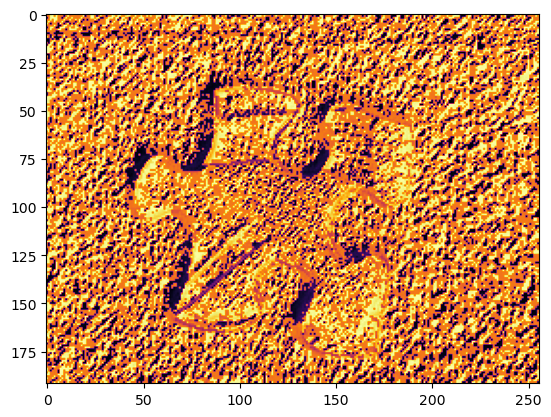

In [123]:
t = HOG_Descriptor(img_83_hog)